# DEMO: EUCLID-BOX

**Euclid-box**: this repository contains the theoretical computation of Euclid observables as well as the computation of the likelihood given some fiducial data. The likelihood is designed to works as an external likelihood for the Bayesian Analysis Code `Cobaya`.

**Install**: To start playing with this notebook, install the ```Likelihood Package``` and its modules according to README.
Alternatively you may be ready to run if ```Cobaya``` and ```CAMB/CLASS``` are installed and the `modules_path` variable points to your `Cobaya` modules

**Cobaya documentation**: https://cobaya.readthedocs.io/en/latest/

In [1]:
# General python imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate 
import time 
import matplotlib.pyplot as plt

# Import Cobaya -need to be installed
from cobaya.run import run
# Import model wrapper of Cobaya to play around
from cobaya.model import get_model
# Import external loglike from the Likelihood Package within cobaya_interface.py
from likelihood.cobaya_interface import EuclidLikelihood

# Where sit your cobaya modules?
modules_path = "/data2/cobaya_modules/"
# Matplotlib params set-up
%matplotlib inline
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=25)
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=25)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')

## CASE 1: Run `Cobaya` with Euclid-Likelihood  and `evaluate` (or any other `sampler` within `Cobaya`)

User-case: simplest case

In [2]:
# We are running the Euclid-Likelihood as an external likelihood class for Cobaya
# Cobaya needs a dictionary or yaml file as input to start running

info = {
    #Which parameters would you like to sample?
    'params': {
        # If the prior dictionary is not passed to a parameter, this parameter is fixed
        'ombh2': 0.022445, 'omch2': 0.1205579307, 'H0': 67, 'tau': 0.0925,
        'mnu': 0.06, 'nnu': 3.046, 'As': 2.12605e-9,
        'ns': 0.96, 
        # Which observational probe would you like to use?
        # 1: photo-z
        # 2: spec
        # 12: both
        'like_selection': 2,
        # Want to use GC+XC+WL in photo? Then full_phot must be True
        'full_photo': True,
        # Bias parameters
        # Photo IST:F values
        'b1_photo': 1.0997727037892875,
        'b2_photo': 1.220245876862528,
        'b3_photo': 1.2723993083933989,
        'b4_photo': 1.316624471897739,
        'b5_photo': 1.35812370570578,
        'b6_photo': 1.3998214171814918,
        'b7_photo': 1.4446452851824907,
        'b8_photo': 1.4964959071110084,
        'b9_photo': 1.5652475842498528,
        'b10_photo': 1.7429859437184225,
        # Spec IST:F values
        'b1_spec': 1.46,
        'b2_spec': 1.61,
        'b3_spec': 1.75,
        'b4_spec': 1.90},
    # Which theory code you want to use, CAMB/CLASS? 
    # Here we use CAMB and specify some CAMB args
    'theory': {'camb': {'stop_at_error': True, 'extra_args':{'num_massive_neutrinos': 1}}},
    # Which sampler do you want to use? Check COBAYA docs to see the list of available samplers
    # Here we use 'evaluate'
    'sampler': {'evaluate': None},  
    # Where have you installed your COBAYA modules (i.e: CAMB, polychord, likelihoods...)?
    'packages_path': modules_path,
    # Where are the results going to be stored, in case the sampler produce output files? 
    'output': 'chains/my_euclid_experiment',
    # Likelihood: we load the Euclid-Likelihood as an external function, and give the name 'Euclid'
    'likelihood': {'Euclid': EuclidLikelihood},
    # How much infomartion you want Cobaya to print? If debug = True, it prints every single detail
    'debug': False,
    # If timing = True, Cobaya returns how much time it took him to make a computation of the posterior
    'timing': True,
    'force': True
    }

In [3]:
# Let's run Cobaya
info_updated, samples = run(info)

[output_mpi] Output to be read-from/written-into folder 'chains', with prefix 'my_euclid_experiment'
[output_mpi] Found existing info files with the requested output prefix: 'chains/my_euclid_experiment'
[output_mpi] Will delete previous products ('force' was requested).
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:
   
[evaluate] Evaluating prior and likelihoods...
[evaluate] log-posterior  = -7.36526
[evaluate] log-prior      = 0
[evaluate]    logprior_0 = 0
[evaluate] log-likelihood = -7.36526
[evaluate]    chi2_Euclid = 14.7305
[evaluate] Derived params:
[euclid] Average evaluation time for Euclid: 8.4441 s  

# Case 2: Run `Cobaya model` with Euclid-Likelihood as external likelihood 

User-case: imagine you are running a MCMC sampling to find the best fit values of $\Lambda CDM$. Because of an unknown reason, your MCMC chains are getting stuck. The `wrapper model` of Cobaya allows you to investigate what's going on within Cobaya at each step of the algorithm. It's a wrapper of the `evaluate` sampler above, which also gives you the possibility of understanding, seeing and retrieving derived parameters and quantities.

In [4]:
# You can reproduce the option 'evaluate' with the model wrapper of Cobaya, which gives you more flexibility
# Create a Cobaya model using the model wrapper of Cobaya. Remember, as input, it needs a yaml or dictionary
t1 = time.time()
model = get_model(info)
print('Time for initialization of the likelihood: ', time.time()-t1)

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
Time for initialization of the likelihood:  9.53818392753601


**Comment**: you see as Cobaya output:
- Model: it tells you Cobaya is using the `model` wrapper and it's reading the info dictionary.
- Prior: which parameters are you sampling? In this case, none, this is why it reminds you that.
- CAMB: it calls the theory code you wanted to use (CAMB/CLASS, in this case, CAMB, and where it is installed)

You see these output repeated twice because you are internally calling `Cobaya`, within the EuclidLikelihood, to calculate the fiducial cosmology.

It takes around 10 seconds to initialize the likelihood (reading ou-level3 data and compute fiducial cosmology) 

In [5]:
# You can have an insight of which theory requirements have been requesting:
# the likelihood is asking to the theory code (aka CAMB)?
print('\n Requirements \n')
print(model.provider.requirement_providers)
# So, what have we requested?
print('\n Requested \n')
print(model.requested())


 Requirements 

{'Pk_interpolator': camb, 'comoving_radial_distance': camb, 'angular_diameter_distance': camb, 'Hubble': camb, 'sigma_R': camb, 'fsigma8': camb, 'CAMB_transfers': camb.transfers}

 Requested 

{'camb.transfers': [{'CAMB_transfers':{'non_linear': False, 'needs_perts': True}}], 'camb': [{'Pk_interpolator':{}}, {'comoving_radial_distance':{'z': array([0.        , 0.04040404, 0.08080808, 0.12121212, 0.16161616,
       0.2020202 , 0.24242424, 0.28282828, 0.32323232, 0.36363636,
       0.4040404 , 0.44444444, 0.48484848, 0.52525253, 0.56565657,
       0.60606061, 0.64646465, 0.68686869, 0.72727273, 0.76767677,
       0.80808081, 0.84848485, 0.88888889, 0.92929293, 0.96969697,
       1.01010101, 1.05050505, 1.09090909, 1.13131313, 1.17171717,
       1.21212121, 1.25252525, 1.29292929, 1.33333333, 1.37373737,
       1.41414141, 1.45454545, 1.49494949, 1.53535354, 1.57575758,
       1.61616162, 1.65656566, 1.6969697 , 1.73737374, 1.77777778,
       1.81818182, 1.85858586, 1.898

In [6]:
# To execute the likelihood with the model wrapper, you need to make an evaluation of the posterior
# Attention: if a parameter is sampled, we need to obtain a value from the prior
# i.e: 
# point = dict(zip(model.parameterization.sampled_params(),
#                 model.prior.sample(ignore_external=True)[0]))
# If all the parameters are fixed, just call the posterior
t1 = time.time()
logposterior = model.logposterior({})
t2 = time.time()
print('Time to compute the logposterior: ', t2-t1)
print('Full log-posterior:')
print('   logposterior: %g' % logposterior.logpost)
print('   logpriors: %r' % dict(zip(list(model.prior), logposterior.logpriors)))
print('   loglikelihoods: %r' % dict(zip(list(model.likelihood), logposterior.loglikes)))
print('   derived params: %r' % dict(zip(list(model.parameterization.derived_params()), logposterior.derived)))

Time to compute the logposterior:  9.326995849609375
Full log-posterior:
   logposterior: -7.36526
   logpriors: {'0': 0.0}
   loglikelihoods: {'Euclid': -7.365261474841869}
   derived params: {}


# Case 3: EuclidLikelihood package

User-case: imagine you have actually loaded the `model` wrapper of Cobaya, but you are unable yet to find what the issue is. In this case, we aim to go one level deeper in the computation: we are going to have a grasp of what EuclidLikelihood actually does (theoretical recipe of the observables, reading the data, computation of the $\chi^2$. 

Disclaimer: the steps below are done internally by `Cobaya` at each step of the sampling procedure within the file `cobaya_interface.py` of the likelihood package.

In [7]:
# Create an instance of the class EuclidLikelihood
like = EuclidLikelihood()
# Initialize default parameters for redshift, k-array, fiducial cosmology...
like.initialize()
# Get the cosmo_dictionary where all the cosmology + theory parameters are saved
# ATTENTION: you need to pass the `cobaya wrapper` model initialized above as an argument of the function
# as well as the parameters of your theory
# When only Cobaya is used, it creates internally this model instance
like.passing_requirements(model, **model.provider.params)
# Update the cosmology dictionary with interpolators + basic quantities such as
# P_gg, P_delta...
# DISCLAIMER: this cosmology dictionary cosmo_dic is an attribute of the class Cosmology but it is also
# saved as an attribute of the class EuclidLikelihood
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], 0.05)
# Show what the cosmo_dic actually contains
print('\nKeys of the cosmo_dic: \n', list(like.cosmo.cosmo_dic.keys()))
print('\nKeys of the input params within cosmo_dic: \n', list(like.cosmo.cosmo_dic['nuisance_parameters'].keys()))

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *local* CAMB from /data2/cobaya_modules/code/CAMB

Keys of the cosmo_dic: 
 ['H0', 'omch2', 'ombh2', 'omnuh2', 'omkh2', 'w', 'mnu', 'tau', 'nnu', 'ns', 'As', 'sigma_8_0', 'comov_dist', 'angular_dist', 'H', 'Pk_interpolator', 'Pk_delta', 'Pgg_phot', 'Pgdelta_phot', 'Pgg_spec', 'Pgdelta_spec', 'Pii', 'Pdeltai', 'Pgi_phot', 'Pgi_spec', 'fsigma8', 'sigma_8', 'c', 'z_win', 'k_win', 'r_z_func', 'd_z_func', 'H_z_func', 'sigma8_z_func', 'fsigma8_z_func', 'MG_mu', 'MG_sigma', 'nuisance_parameters', 'D_z_k', 'f_z_k']

Keys of the input params within cosmo_dic: 
 ['like_selection', 'full_photo', 'b1_photo', 'b2_photo', 'b3_photo', 'b4_photo', 'b5_photo', 'b6_photo', 'b7_photo', 'b8_photo', 'b9_photo', 'b10_photo', 'b1_spec', 'b2_spec', 'b3

### Plot internal quantities and cosmological observables

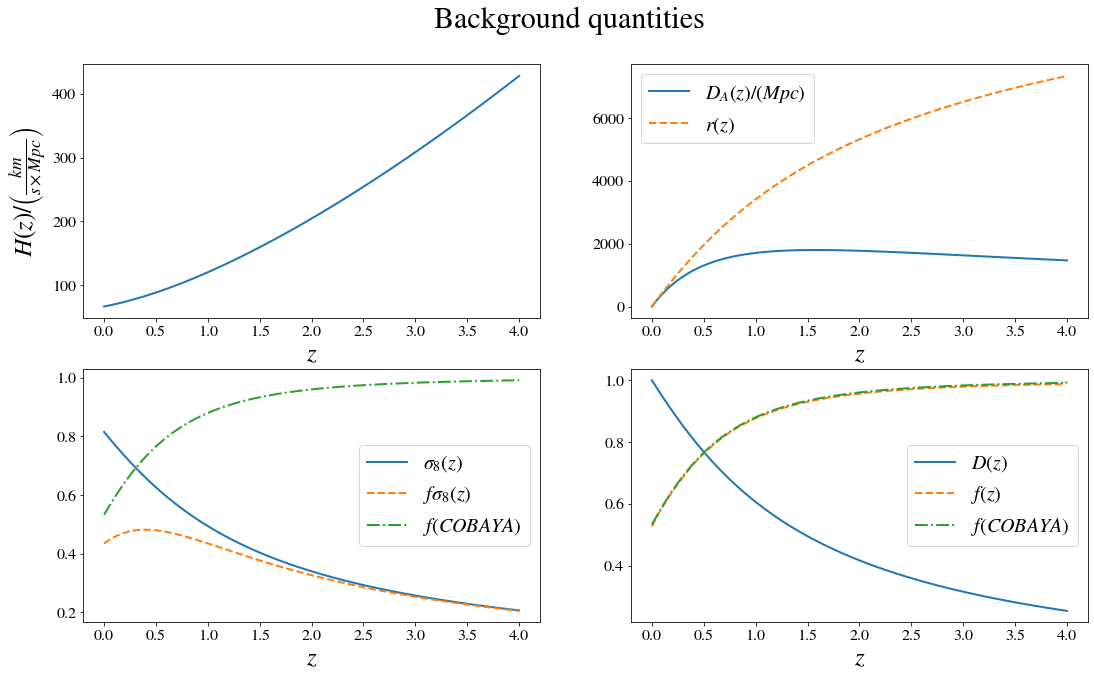

In [15]:
# Let's plot the background quantities of cosmo_dic
fig, axs = plt.subplots(2, 2, figsize=(18,10))
fig.suptitle('Background quantities')
axs[0, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['H_z_func'](like.cosmo.cosmo_dic['z_win']))
axs[0, 0].set_xlabel(r'$z$')
axs[0, 0].set_ylabel(r'$H(z) / \left( \frac{km}{s\times Mpc}\right)$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['d_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$D_A(z) / (Mpc)$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['r_z_func'](like.cosmo.cosmo_dic['z_win']), '--',
              label = r'$r(z)$')
axs[0, 1].set_xlabel(r'$z$')
axs[0, 1].legend()
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['sigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$\sigma_8(z)$')
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['fsigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              '--', label = r'$f\sigma_8(z)$')
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], 
               like.cosmo.cosmo_dic['fsigma8_z_func'](like.cosmo.cosmo_dic['z_win'])/like.cosmo.cosmo_dic['sigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              '-.', label = r'$f (COBAYA)$')
axs[1, 0].set_xlabel(r'$z$')
axs[1, 0].legend()
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['D_z_k'],
              label = r'$D(z)$')
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['f_z_k'](like.cosmo.cosmo_dic['z_win']), '--',
               label = r'$f(z)$')
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], 
               like.cosmo.cosmo_dic['fsigma8_z_func'](like.cosmo.cosmo_dic['z_win'])/like.cosmo.cosmo_dic['sigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              '-.', label = r'$f (COBAYA)$')
axs[1, 1].set_xlabel(r'$z$');
axs[1, 1].legend()
plt.subplots_adjust(top=0.90)

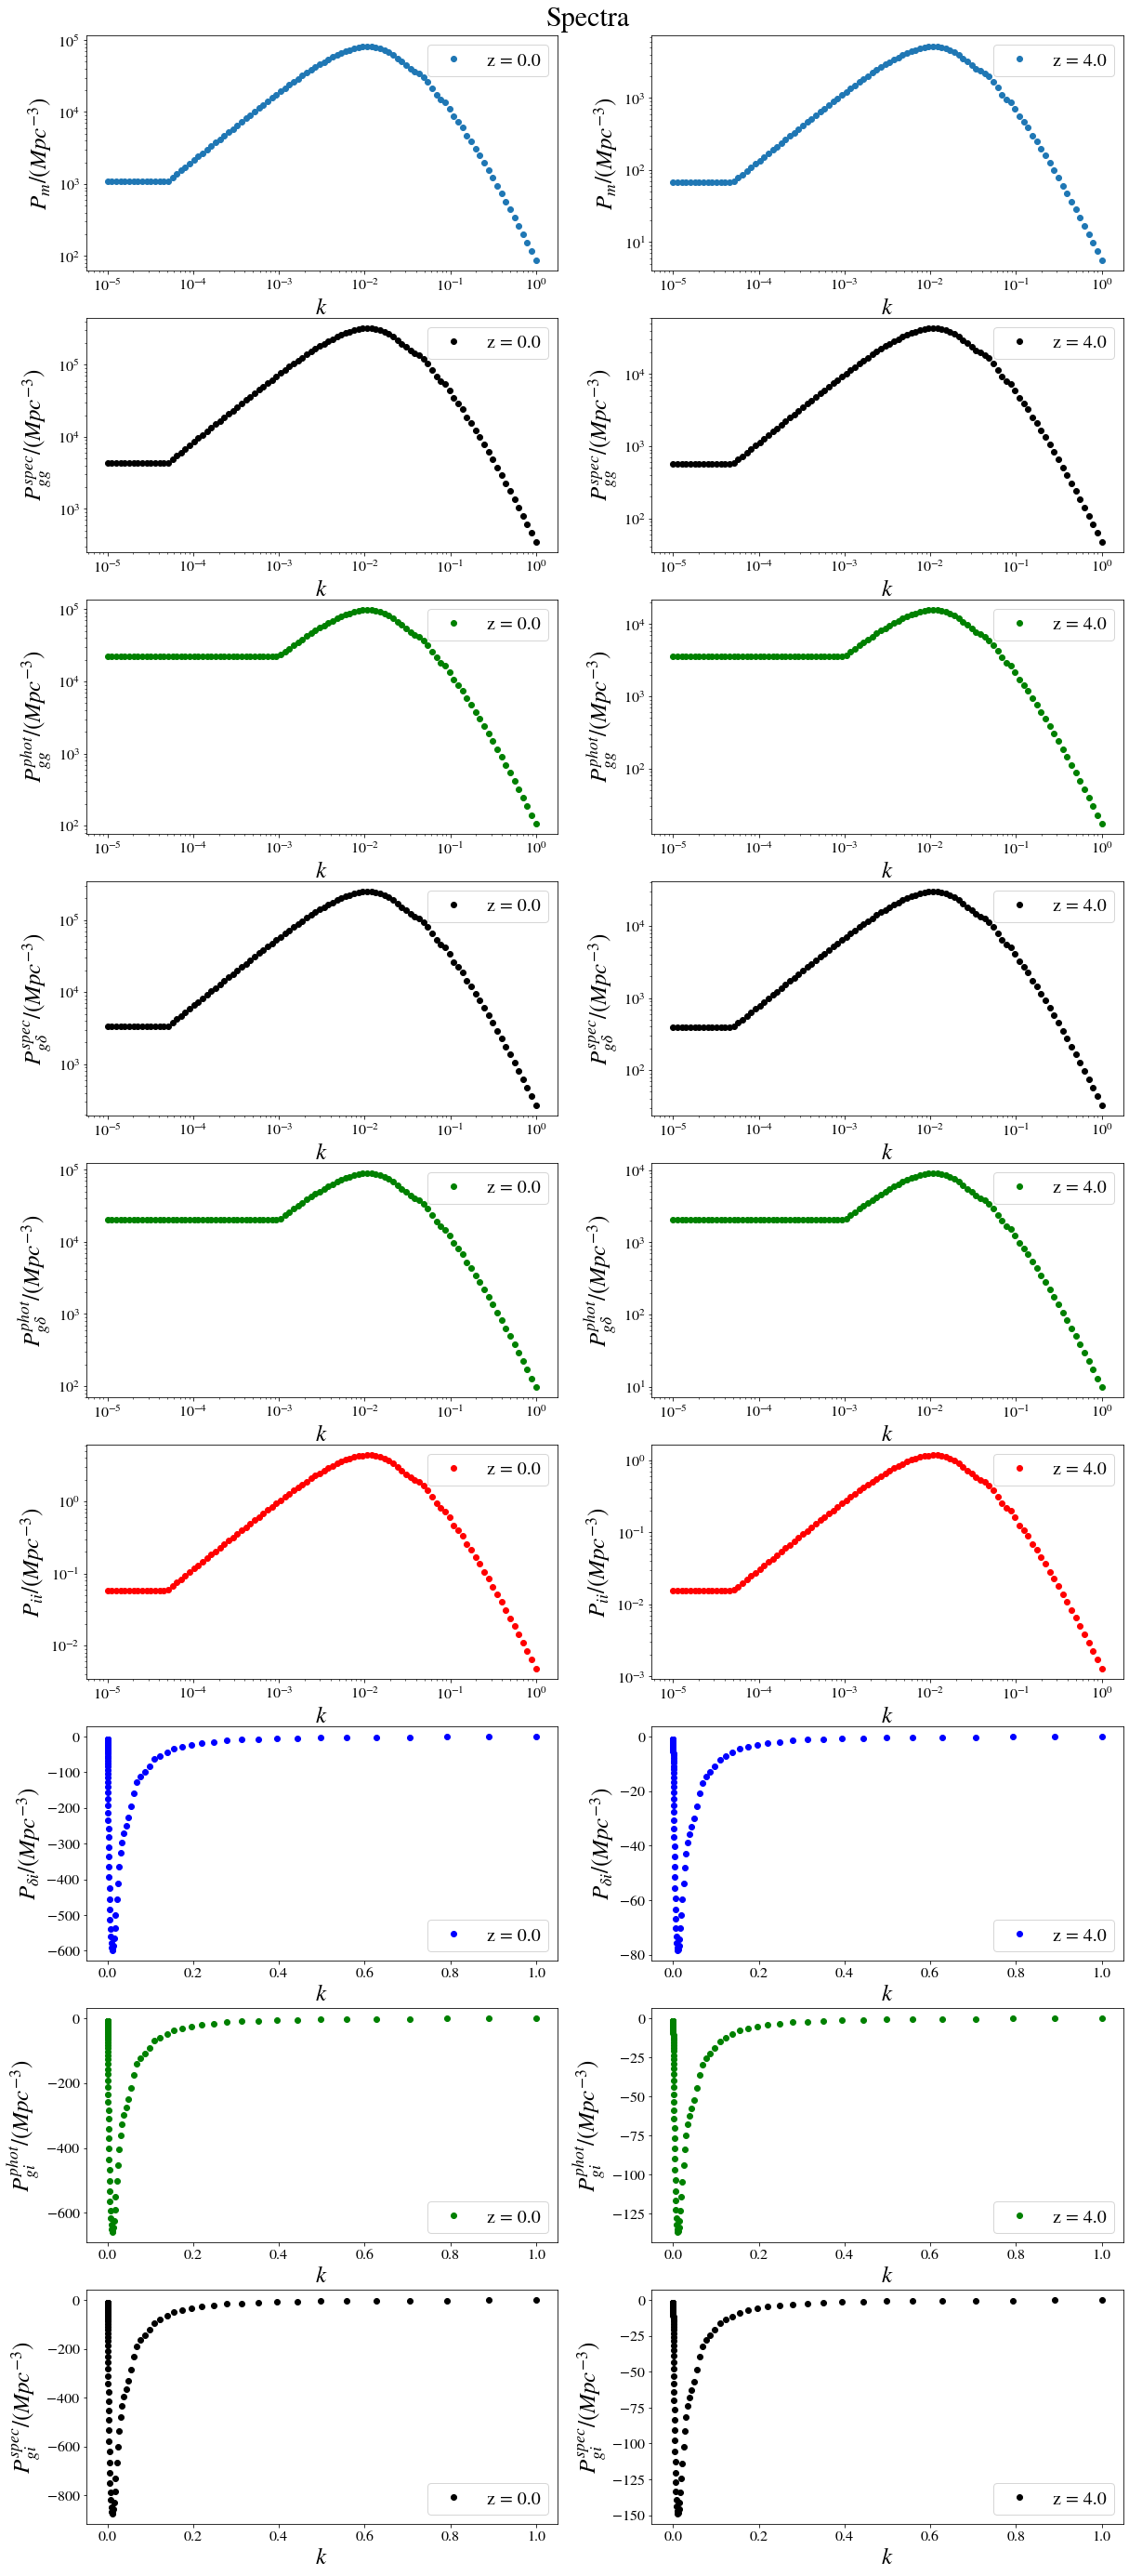

In [9]:
# Let's plot the matter power spectrum and other spectra quantities
# 'Pgg_spec', 'Pgg_phot', 'Pgdelta_phot', 'Pgdelta_spec', 'Pii', 'Pdeltai', 'Pgi_phot', 'Pgi_spec', 
fig, axs = plt.subplots(9, 2, figsize=(20,44))
fig.suptitle('Spectra')

ks=np.logspace(-5, 0, 100)
axs[0, 0].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][0], ks), 'o', 
           label=r"z = {}".format(like.cosmo.cosmo_dic['z_win'][0]))
axs[0, 0].set_xlabel(r'$k$')
axs[0, 0].set_ylabel(r'$P_m / (Mpc^{-3})$')
axs[0, 0].legend()
#------
axs[0, 1].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][-1], ks), 'o', 
           label=r"z = {}".format(like.cosmo.cosmo_dic['z_win'][-1]))
axs[0, 1].set_xlabel(r'$k$')
axs[0, 1].set_ylabel(r'$P_m / (Mpc^{-3})$')
axs[0, 1].legend()
#------
for i, k in enumerate(ks):
    axs[1, 0].loglog(k, like.cosmo.cosmo_dic['Pgg_spec'](
    like.cosmo.cosmo_dic['z_win'][0], k, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[1, 1].loglog(k, like.cosmo.cosmo_dic['Pgg_spec'](
    like.cosmo.cosmo_dic['z_win'][-1], k, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[1, 0].set_xlabel(r'$k$')
axs[1, 0].set_ylabel(r'$P_{gg}^{spec} / (Mpc^{-3})$')
axs[1, 1].set_xlabel(r'$k$')
axs[1, 1].set_ylabel(r'$P_{gg}^{spec} / (Mpc^{-3})$')
axs[1, 0].legend()
axs[1, 1].legend()

#------
for i, k in enumerate(ks):
    axs[2, 0].loglog(k, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[2, 1].loglog(k, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[2, 0].set_xlabel(r'$k$')
axs[2, 0].set_ylabel(r'$P_{gg}^{phot} / (Mpc^{-3})$')
axs[2, 1].set_xlabel(r'$k$')
axs[2, 1].set_ylabel(r'$P_{gg}^{phot} / (Mpc^{-3})$')
axs[2, 0].legend()
axs[2, 1].legend()

#------
for i, k in enumerate(ks):
    axs[3, 0].loglog(k, like.cosmo.cosmo_dic['Pgdelta_spec'](
    like.cosmo.cosmo_dic['z_win'][0], k, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[3, 1].loglog(k, like.cosmo.cosmo_dic['Pgdelta_spec'](
    like.cosmo.cosmo_dic['z_win'][-1], k, 1), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[3, 0].set_xlabel(r'$k$')
axs[3, 0].set_ylabel(r'$P_{g\delta}^{spec} / (Mpc^{-3})$')
axs[3, 1].set_xlabel(r'$k$')
axs[3, 1].set_ylabel(r'$P_{g\delta}^{spec} / (Mpc^{-3})$')
axs[3, 0].legend()
axs[3, 1].legend()


#------
for i, k in enumerate(ks):
    axs[4, 0].loglog(k, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[4, 1].loglog(k, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[4, 0].set_xlabel(r'$k$')
axs[4, 0].set_ylabel(r'$P_{g\delta}^{phot} / (Mpc^{-3})$')
axs[4, 1].set_xlabel(r'$k$')
axs[4, 1].set_ylabel(r'$P_{g\delta}^{phot} / (Mpc^{-3})$')
axs[4, 0].legend()
axs[4, 1].legend()

#------
for i, k in enumerate(ks):
    axs[5, 0].loglog(k, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'ro', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[5, 1].loglog(k, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'ro', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[5, 0].set_xlabel(r'$k$')
axs[5, 0].set_ylabel(r'$P_{ii} / (Mpc^{-3})$')
axs[5, 1].set_xlabel(r'$k$')
axs[5, 1].set_ylabel(r'$P_{ii} / (Mpc^{-3})$')
axs[5, 0].legend()
axs[5, 1].legend()

#------
for i, k in enumerate(ks):
    axs[6, 0].plot(k, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'bo', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[6, 1].plot(k, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'bo', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[6, 0].set_xlabel(r'$k$')
axs[6, 0].set_ylabel(r'$P_{\delta i} / (Mpc^{-3})$')
axs[6, 1].set_xlabel(r'$k$')
axs[6, 1].set_ylabel(r'$P_{\delta i} / (Mpc^{-3})$')
axs[6, 0].legend(loc=4)
axs[6, 1].legend(loc=4)

#------
for i, k in enumerate(ks):
    axs[7, 0].plot(k, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[7, 1].plot(k, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[7, 0].set_xlabel(r'$k$')
axs[7, 0].set_ylabel(r'$P_{gi}^{phot} / (Mpc^{-3})$')
axs[7, 1].set_xlabel(r'$k$')
axs[7, 1].set_ylabel(r'$P_{gi}^{phot} / (Mpc^{-3})$')
axs[7, 0].legend(loc=4)
axs[7, 1].legend(loc=4)

#------
for i, k in enumerate(ks):
    axs[8, 0].plot(k, like.cosmo.cosmo_dic['Pgi_spec'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[8, 1].plot(k, like.cosmo.cosmo_dic['Pgi_spec'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'ko', label=r"z = {}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[8, 0].set_xlabel(r'$k$')
axs[8, 0].set_ylabel(r'$P_{gi}^{spec} / (Mpc^{-3})$')
axs[8, 1].set_xlabel(r'$k$')
axs[8, 1].set_ylabel(r'$P_{gi}^{spec} / (Mpc^{-3})$')
axs[8, 0].legend(loc=4)
axs[8, 1].legend(loc=4)

plt.subplots_adjust(top=0.97)


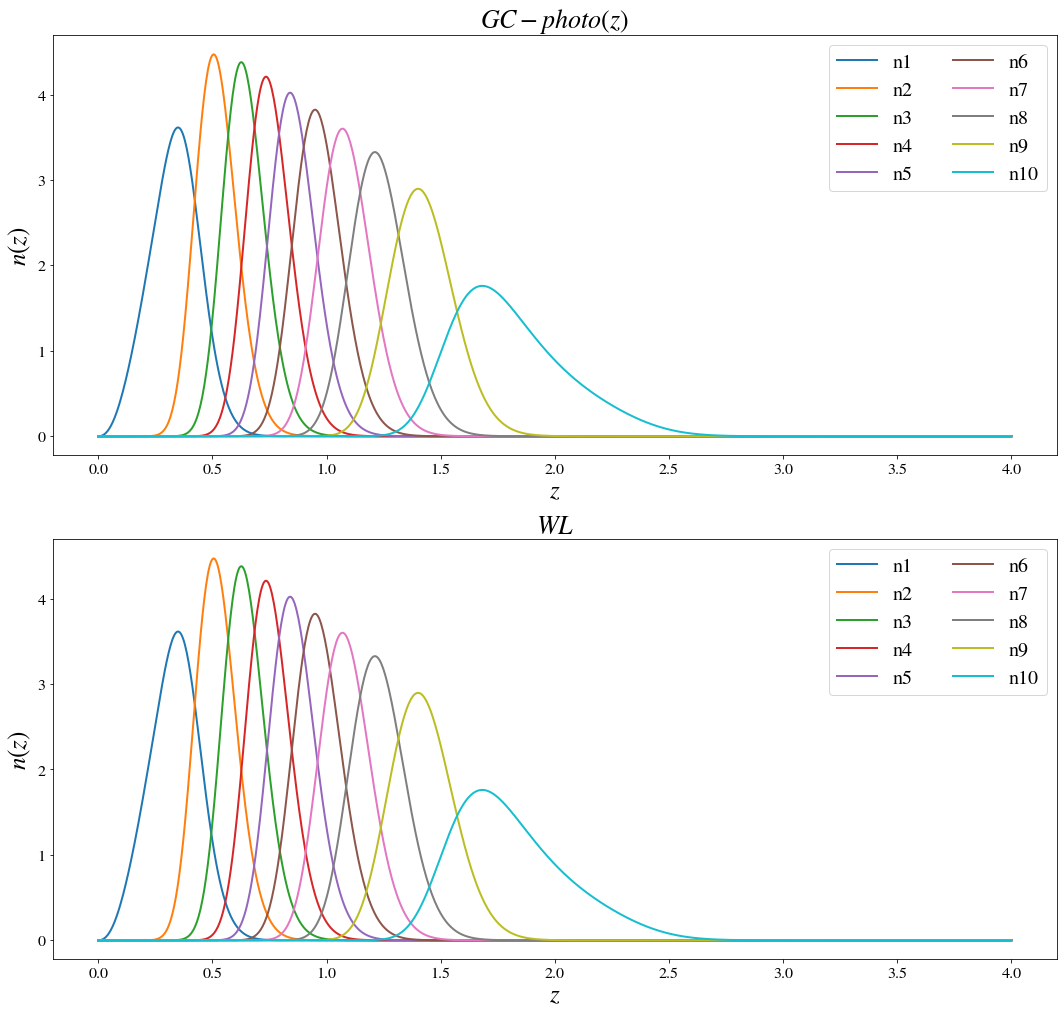

In [10]:
# We can also plot the initial data read by the like_calc module (class Euclike). 
# DISCLAIMER: the data is read in the reader module, but it is saved as attribute of the Euclike class too.
# The instance of the Euclike class is saved as an attribute of the EuclidLikelihood class as well.
# i.e: let's plot the galaxy distributions for GC-photo(z) and WL (AT THE MOMENT, THEY ARE THE SAME)
zs = np.linspace(0, 4, 1000)
fig, axs = plt.subplots(2, 1, figsize=(18,17))
for key, value in like.likefinal.data_ins.nz_dict_GC_Phot.items():
    axs[0].plot(zs, value(zs), label = key)
for key, value in like.likefinal.data_ins.nz_dict_WL.items():
    axs[1].plot(zs, value(zs), label = key)
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$n(z)$')
axs[0].set_title(r'$GC-photo(z)$')
axs[0].legend(ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$n(z)$')
axs[1].set_title(r'$WL$')
axs[1].legend(ncol=2);
#plt.subplots_adjust(top=0.90)

In [11]:
# We can also plot the window functions for the photometric observables
# For that, you need to import the photo class and read the cosmology dictionary and the n(z) distributions above
from likelihood.photometric_survey.photo import Photo
photo = Photo(like.cosmo.cosmo_dic, like.likefinal.data_ins.nz_dict_WL, like.likefinal.data_ins.nz_dict_GC_Phot)

ATTENTION: WL kernel computation takes a bit of time
bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
bin: 8
bin: 9
bin: 10


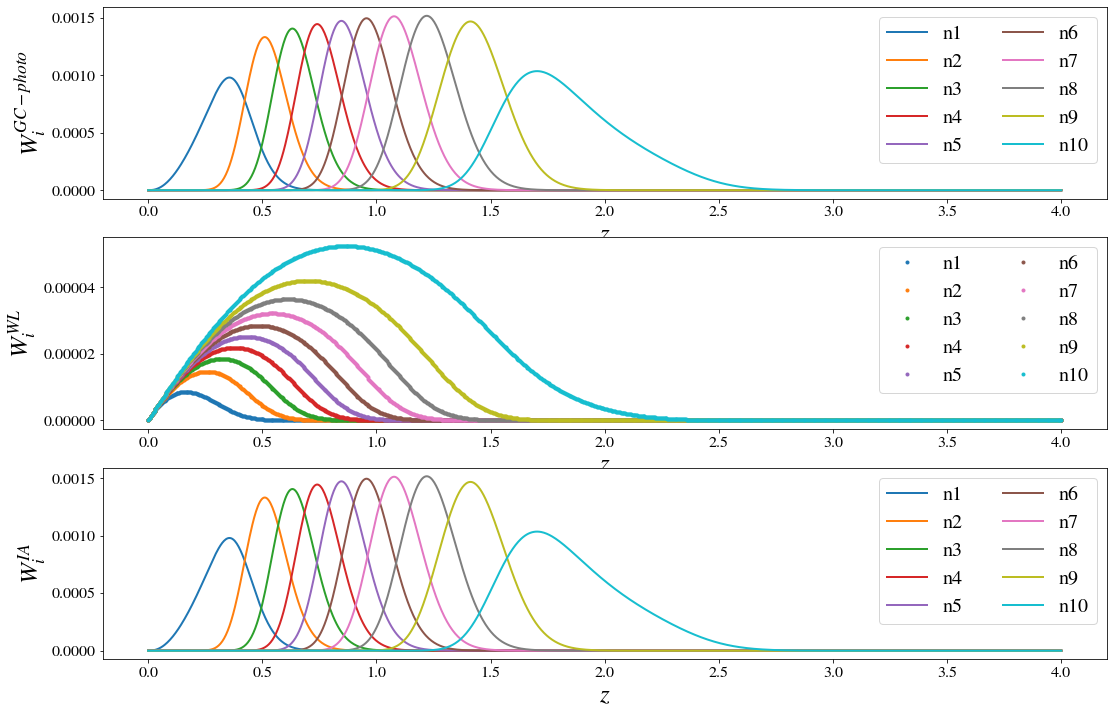

In [12]:
import matplotlib.colors as mcolors
color = list(mcolors.TABLEAU_COLORS.values())
fig, axs = plt.subplots(3, 1, figsize=(18,12))
print('ATTENTION: WL kernel computation takes a bit of time')
# DISCLAIMER: photo.GC_window accepts an array for z, but WL_window does not. 
# This is why we need to go through a foor-loop for WL
for i in range(0, 10):
    print('bin: {}'.format(i+1))
    axs[0].plot(zs, photo.GC_window(zs, i+1), '-', label='n{}'.format(i+1))
    for j, z in enumerate(zs):
        axs[1].plot(z, photo.WL_window(z, i+1), '.', color = color[i], label='n{}'.format(i+1) if j == 0 else "")
    axs[2].plot(zs, photo.IA_window(zs, i+1), label='n{}'.format(i+1))
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$W_i^{GC-photo}$')
axs[0].legend(ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$W_i^{WL}$')
axs[1].legend(ncol=2);
axs[2].set_xlabel(r'$z$')
axs[2].set_ylabel(r'$W_i^{IA}$')
axs[2].legend(ncol=2);

### Plot Euclid final observables

We can use the auxiliary module of the Euclid-box to plot the final observables

In [16]:
# We import the Plotter Class
from likelihood.auxiliary.plotter import Plotter

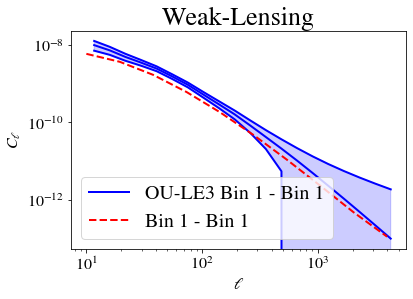

In [18]:
# Weak-Lensing

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

pl_inst = Plotter(cosmo_dic=like.cosmo.cosmo_dic)

ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='WL')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='WL', pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=16)
ax1.set_ylabel(r'$C_\ell$', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Weak-Lensing')
ax1.legend()

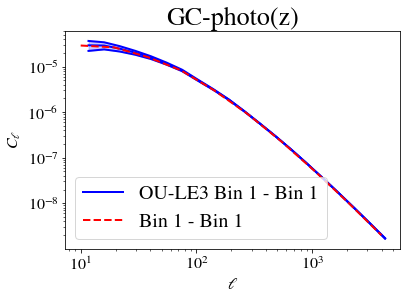

In [20]:
# GC-photo(z)
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='GC-Phot')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='GC-Phot', pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=16)
ax1.set_ylabel(r'$C_\ell$', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('GC-photo(z)')
ax1.legend()

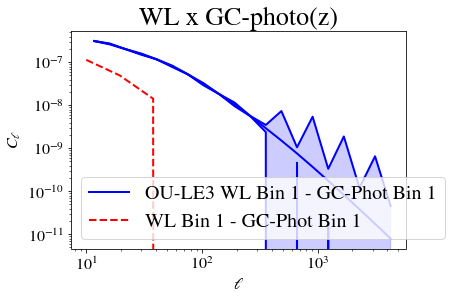

In [21]:
# Cross-correlation WL x GC-photo(z)

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_Cl_XC(1, 1, ax1)
ax1 = pl_inst.plot_Cl_XC(np.logspace(1, 3.6, 10), 1, 1, ax1, pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=16)
ax1.set_ylabel(r'$C_\ell$', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('WL x GC-photo(z)')
ax1.legend()

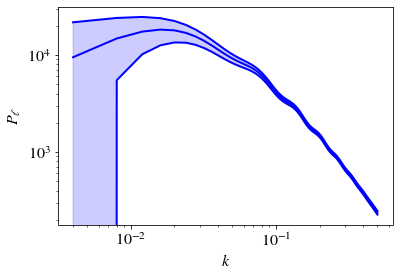

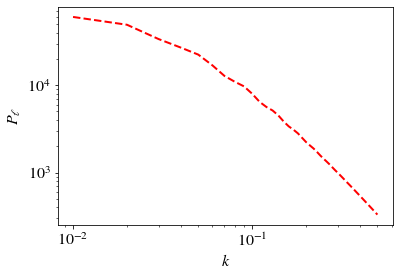

In [22]:
# GC-spec
# Note: The internal and external spectra are currently plotted seperately 
# due to the fact that the external spectra are supplied in different units. 
# Once this is corrected, this notebook should be editted to place both on the same plot.

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_GC_spec("1.2", 2, ax1, pl_label='a')
ax1.set_xlabel(r'$k$', fontsize=16)
ax1.set_ylabel(r'$P_\ell$', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = pl_inst.plot_GC_spec_multipole(1.2, np.linspace(0.01, 0.5), 2, ax2, pl_colour='r', pl_linestyle='--')
ax2.set_xlabel(r'$k$', fontsize=16)
ax2.set_ylabel(r'$P_\ell$', fontsize=16)
ax2.set_xscale('log')
ax2.set_yscale('log')